### Step 1: Problem statement

In this challenge, the ask it to complete the analysis of what sorts of people were likely to survive. In particular, the ask is to apply the tools of machine learning to predict which passengers survived the tragedy.

### Step 2: Collecting data

In this step we will import required libraries and data from csv files.

In [1136]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Pandas and NumPy
import pandas as pd, numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [1137]:
# Importing all datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Step 3: Exploratory data analysis

In this challenge, the ask it to complete the analysis of what sorts of people were likely to survive. In particular, the ask is to apply the tools of machine learning to predict which passengers survived the tragedy.


| Variable | Definition | Key |
| --- | --- | --- |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| survival | Survival | 0 = No, 1 = Yes |
| sex | Sex | Male/Female |
| Age | Age in years |  |
| sibsp | # of siblings / spouses aboard the Titanic |  |
| parch | # of parents / children aboard the Titanic |  |
| ticket | Ticket number |  |
| fare | Passenger fare |  |
| cabin | Cabin number |  |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |	

In [1138]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Step 4: Feature engineering

In this step we will perform action on features to make them more meaningful.

In [1139]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method."""
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [1140]:
print("percent of data with outliers values:", round((train.loc[Outliers_to_drop].shape[0]/train.shape[0])*100,2))

percent of data with outliers values: 1.12


In [1141]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [1142]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
Age            1043 non-null float64
Cabin          292 non-null object
Embarked       1297 non-null object
Fare           1298 non-null float64
Name           1299 non-null object
Parch          1299 non-null int64
PassengerId    1299 non-null int64
Pclass         1299 non-null int64
Sex            1299 non-null object
SibSp          1299 non-null int64
Survived       881 non-null float64
Ticket         1299 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 96.4+ KB


In [1143]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [1144]:
dataset.columns[dataset.isna().sum()!=0]

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Survived'], dtype='object')

(-15, 522.3292)

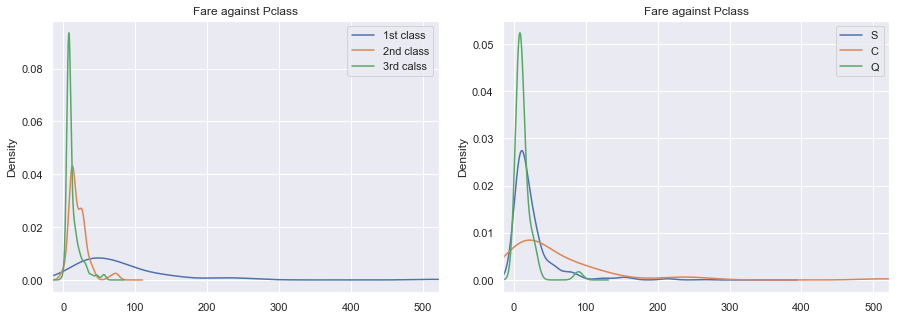

In [1145]:
fig=plt.figure(figsize=(15,5))
plt.subplot2grid((1,4),(0,0),colspan=2)
fig.subplots_adjust(hspace=.5,wspace = 0.4)
for i in [1,2,3]:
    train.Fare[(train.Pclass==i) & (train.Fare.notnull())].plot(kind='kde')
plt.title("Fare against Pclass")
plt.legend(("1st class","2nd class","3rd calss"))
plt.xlim(-15,train.Fare[(train.Fare.notnull())].max()+10)

plt.subplot2grid((1,4),(0,2),colspan=2)
for i in ["S","C","Q"]:
    train.Fare[(train.Embarked==i) & (train.Fare.notnull())].plot(kind='kde')
plt.title("Fare against Pclass")
plt.legend(("S","C","Q"))
plt.xlim(-15,train.Fare[(train.Fare.notnull())].max()+10)

In [1146]:
dataset['Fare'].fillna(dataset.groupby(["Pclass",'Embarked'])['Fare'].transform("median"),inplace=True)

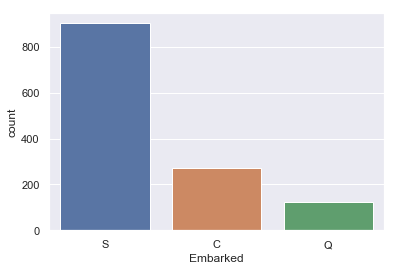

In [1147]:
sns.countplot(x="Embarked",data=dataset)

In [1148]:
dataset['Embarked'].fillna(dataset['Embarked'].value_counts().index[0],inplace=True)

In [1149]:
dataset['Cabin']=dataset['Cabin'].str[0]
train=dataset[~dataset.Survived.isnull()]
test=dataset[dataset.Survived.isnull()]

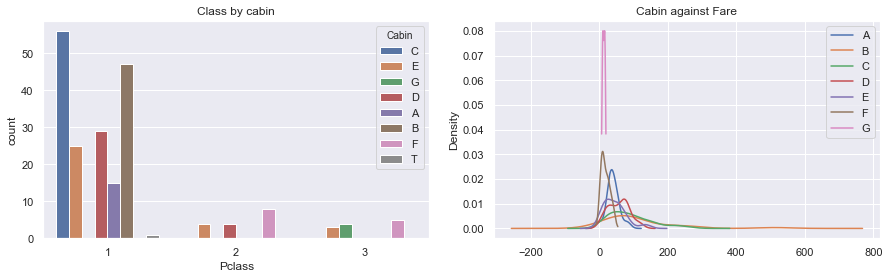

In [1150]:
fig=plt.figure (figsize=(15,10))
fig.subplots_adjust(hspace=.5,wspace = 0.4)

plt.subplot2grid((2,4),(0,0),colspan=2)
sns.countplot (x='Pclass', hue='Cabin',data=train)
plt.title("Class by cabin")

plt.subplot2grid((2,4),(0,2),colspan=2)
for i in ['A','B','C','D','E','F','G']:
    train.Fare[train.Cabin==i].plot(kind='kde')
plt.title("Cabin against Fare")
plt.legend(('A','B','C','D','E','F','G'))

In [1151]:
dataset['Cabin']=dataset.groupby(['Pclass','Fare'])['Cabin'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Z"))

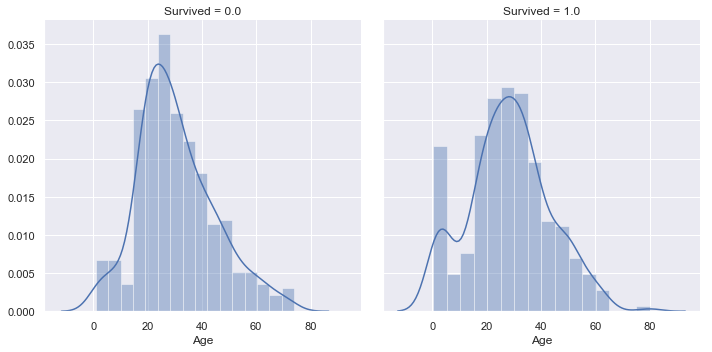

In [1152]:
g = sns.FacetGrid(train, col='Survived',height=5,aspect=1)
g = g.map(sns.distplot, "Age")

(-15, 90.0)

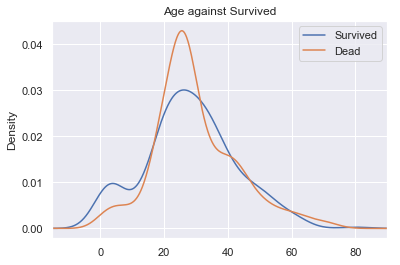

In [1153]:
plt.subplot2grid((1,2),(0,0),colspan=2)
for i in [1,0]:
    Train.Age[(Train.Survived==i) & (Train.Survived.notnull())].plot(kind='kde')
plt.title("Age against Survived")
plt.legend(("Survived","Dead"))
plt.xlim(-15,Train.Age[(Train.Survived.notnull())].max()+10)

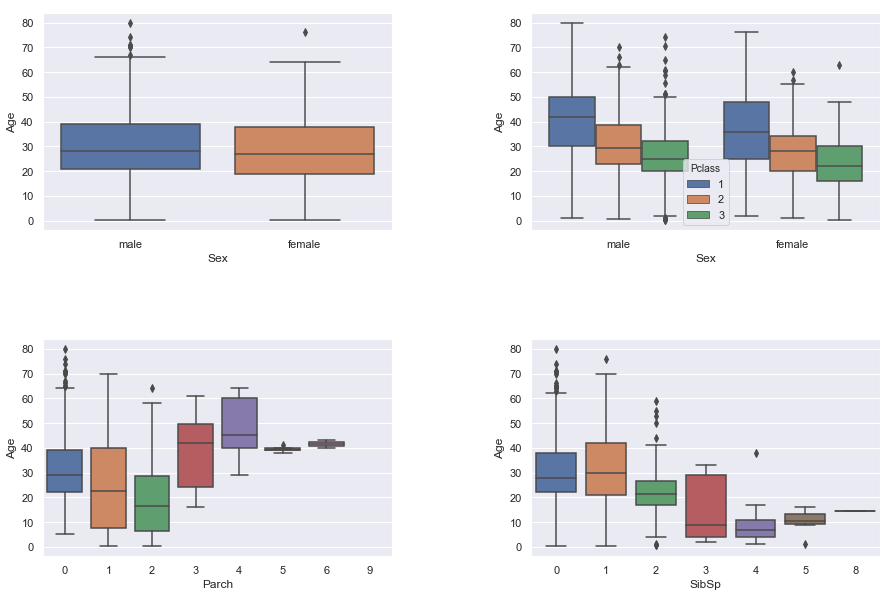

In [1154]:
fig,ax=plt.subplots(2,2,figsize=(15,10))
ax=ax.flat
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box",ax=ax[0])
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box",ax=ax[1])
g.set_ylabels("survival probability")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box",ax=ax[2])
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box",ax=ax[3])
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)

In [1155]:
dataset["Title"]=(dataset["Name"].str.split(",", n = 1, expand = True))[1].str.split(".", n = 1, expand = True)[0]
dataset["Title"]=dataset["Title"].str.strip()

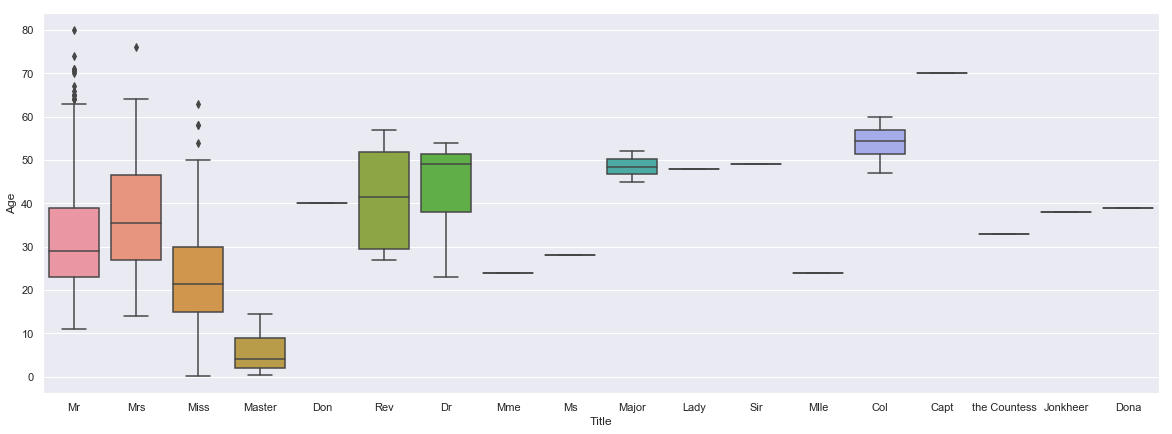

In [1156]:
fig,ax=plt.subplots(figsize=(20,7))
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.factorplot(y="Age",x="Title",data=dataset,kind="box",ax=ax)
plt.tight_layout()
plt.close(2)

In [1157]:
dataset["Title"]=dataset["Title"].apply(lambda x: 'Master' if x in ['Master'] else ('Miss' if x in ['Miss','Ms','Mile','Mme']
                                                                                    else ('Mrs' if x=='Mrs' 
                                                                                    else ('Mr' if x in ['Mr'] 
                                                                                    else 'Others'))))

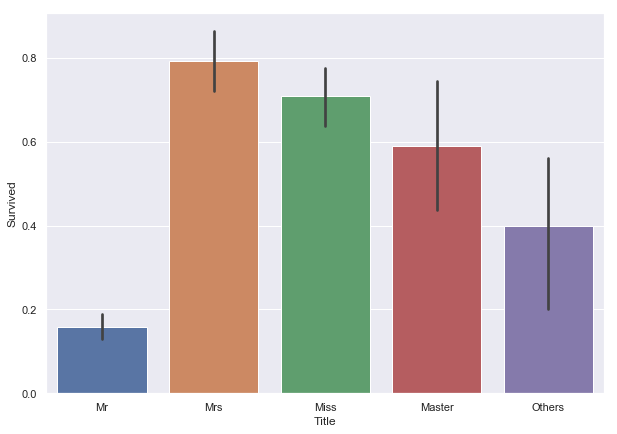

In [1158]:
fig,ax=plt.subplots(figsize=(10,7))
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.factorplot(y="Survived",x="Title",data=dataset,kind="bar",ax=ax)
plt.tight_layout()
plt.close(2)

In [1159]:
import math
AgeMedian=dataset['Age'].median()
dataset['Age']=dataset.groupby(['Pclass','SibSp','Parch','Title'])['Age'].transform(
    lambda x: x.fillna(x.median() if not math.isnan(x.median()) else AgeMedian))

In [1160]:
train=dataset[~dataset.Survived.isnull()]
test=dataset[dataset.Survived.isnull()]

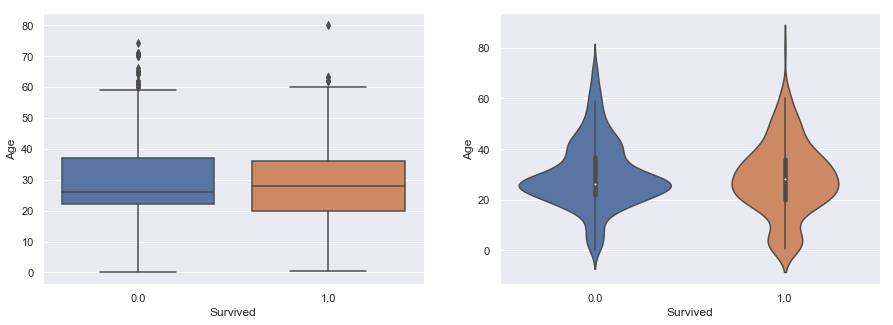

In [1161]:
f,ax=plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box",ax=ax[0])
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin",ax=ax[1])
plt.close(2)
plt.close(3)
fig.show()

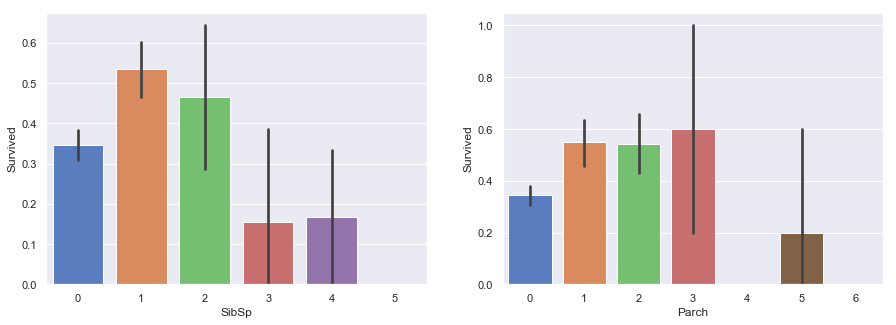

In [1162]:
f,ax=plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(hspace=.5,wspace = 0.4)

g=sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , palette = "muted",ax=ax[0])
g.despine(left=True)
g = g.set_ylabels("survival probability")

g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 ,palette = "muted",ax=ax[1])
g.despine(left=True)
g = g.set_ylabels("survival probability")
plt.close(2)
plt.close(3)
fig.show()

In [1163]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

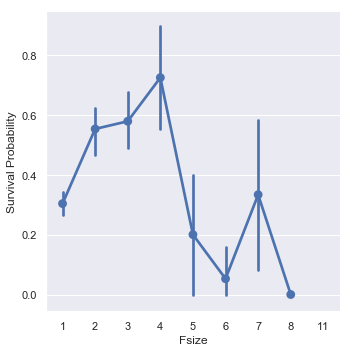

In [1164]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

In [1165]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  2 <= s <= 3  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 4 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

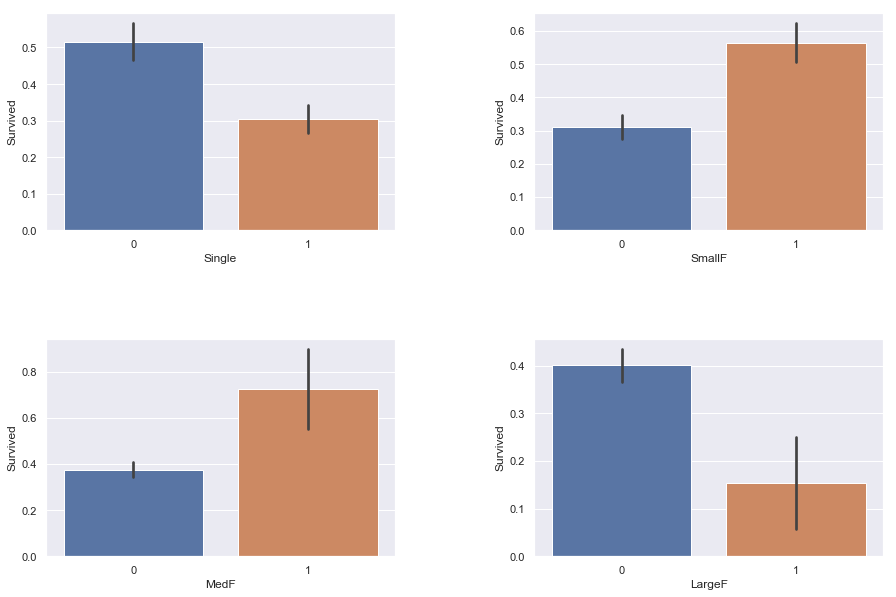

In [1166]:
fig,ax=plt.subplots(2,2,figsize=(15,10))
ax=ax.flat
fig.subplots_adjust(hspace=.5,wspace = 0.4)
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar",ax=ax[0])
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar",ax=ax[1])
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar",ax=ax[2])
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar",ax=ax[3])
g = g.set_ylabels("Survival Probability")
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)

In [1167]:
dataset.to_csv("testing.csv")

In [1168]:
dataset.drop(['Name','Ticket'],axis=1,inplace=True)

In [1169]:
# lets create dummies.
# Here we will first convert the data from categorical to numerical.
# We are not converting Company names now, as this will lead to more number of columns and logically also it doesn't
# add up to have brand name for price decision.
def CreateDummies(df_in, col_name):
    Dummy_Value=pd.get_dummies(df_in[col_name],col_name,prefix_sep="_",drop_first=True)
    df_in=pd.concat([df_in,Dummy_Value],axis=1)
    df_in.drop(col_name,axis=1,inplace=True)
    return df_in

ColumnList= ['Cabin','Embarked','Pclass','Sex','Title']
for columns in ColumnList:
    dataset=CreateDummies(dataset,columns)

In [1170]:
dataset.set_index("PassengerId",inplace=True)

In [1171]:
train=dataset[~dataset.Survived.isnull()]
test=dataset[dataset.Survived.isnull()]

In [1172]:
train.describe()

,Age,Fare,Parch,SibSp,Survived,Fsize,Single,SmallF,MedF,LargeF,...,Cabin_Z,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Sex_male,Title_Miss,Title_Mr,Title_Mrs,Title_Others
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,...,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,29.265993,31.121566,0.363224,0.455165,0.385925,1.818388,0.609535,0.298524,0.032917,0.059024,...,0.527809,0.087401,0.721907,0.208854,0.549376,0.649262,0.203178,0.582293,0.141884,0.028377
std,13.620629,47.996249,0.791839,0.871571,0.487090,1.382086,0.488132,0.457871,0.178521,0.235803,...,0.499510,0.282582,0.448314,0.406720,0.497839,0.477472,0.402593,0.493462,0.349130,0.166141
min,0.170000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.895800,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,14.454200,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,36.500000,30.500000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,80.000000,512.329200,6.000000,5.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modelling ##
Here we will apply different models to find best suited for esembler 

In [1173]:
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [1174]:
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)

In [1175]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [1176]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [1179]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 1 to 891
Data columns (total 26 columns):
Age             881 non-null float64
Fare            881 non-null float64
Parch           881 non-null int64
SibSp           881 non-null int64
Fsize           881 non-null int64
Single          881 non-null int64
SmallF          881 non-null int64
MedF            881 non-null int64
LargeF          881 non-null int64
Cabin_B         881 non-null uint8
Cabin_C         881 non-null uint8
Cabin_D         881 non-null uint8
Cabin_E         881 non-null uint8
Cabin_F         881 non-null uint8
Cabin_G         881 non-null uint8
Cabin_T         881 non-null uint8
Cabin_Z         881 non-null uint8
Embarked_Q      881 non-null uint8
Embarked_S      881 non-null uint8
Pclass_2        881 non-null uint8
Pclass_3        881 non-null uint8
Sex_male        881 non-null uint8
Title_Miss      881 non-null uint8
Title_Mr        881 non-null uint8
Title_Mrs       881 non-null uint8
Title_Others    

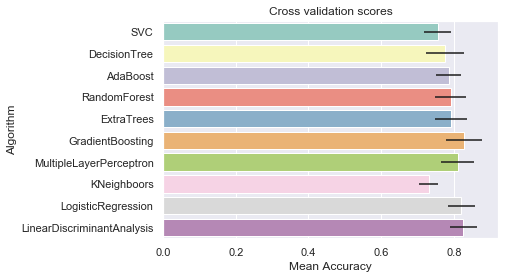

In [1180]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [1181]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 484 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    6.7s finished


In [1183]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   42.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.9min finished


0.8342792281498297

In [1184]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.6min finished


0.8331441543700341

In [1185]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   47.7s finished


0.8308740068104427

In [1186]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.0s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.3min finished


0.8183881952326901

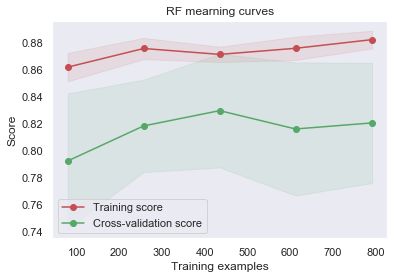

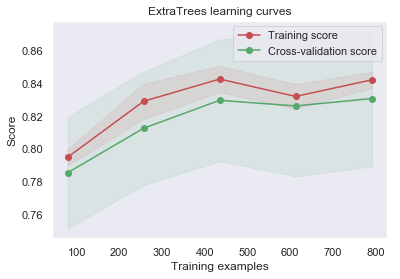

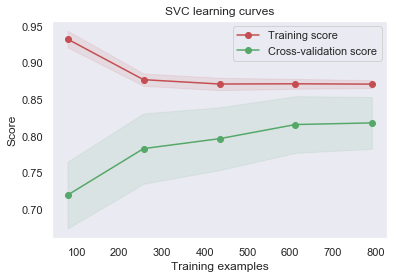

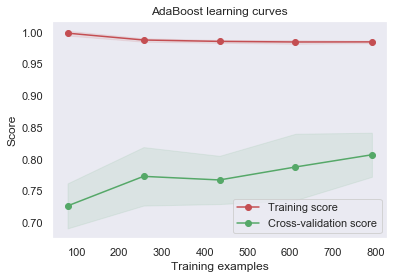

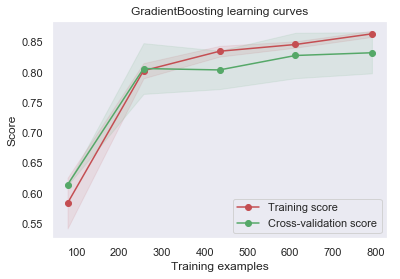

In [1187]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

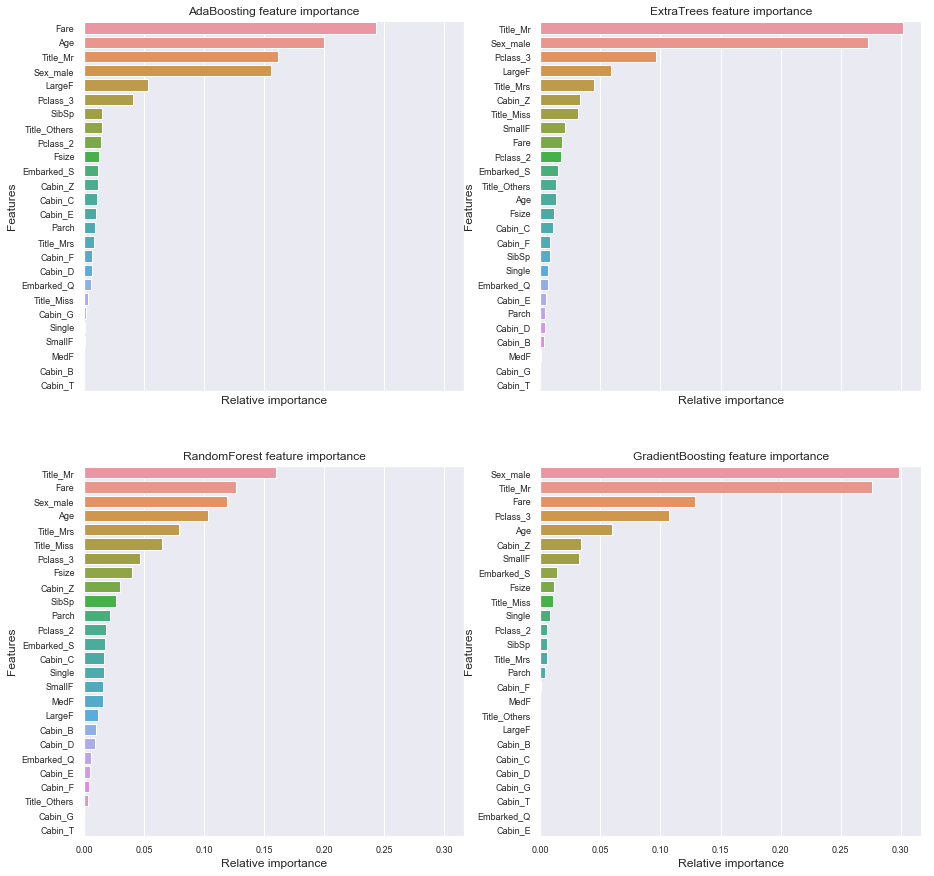

In [1188]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

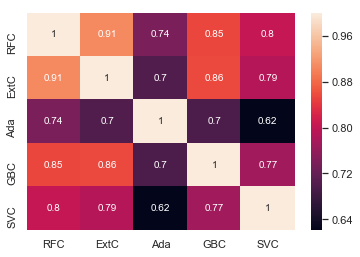

In [1189]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [1190]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [1198]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([pd.DataFrame(test.index),test_Survived],axis=1)

results.to_csv("New_Result.csv",index=False)